In [29]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline

import os
import pandas as pd
import skimage.io
from skimage.transform import resize
import torchvision.utils

import time
import random
import math
import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
from IPython.display import clear_output


In [2]:
SEED = 1234

torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
from torchvision import transforms
batch_size = 64
# MNIST Dataset
train_dataset = datasets.MNIST(root='./mnist_data/', train=True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./mnist_data/', train=False, transform=transforms.ToTensor(), download=True)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



# 1. Vanilla Autoencoder 


In [4]:
def KL_divergence(mu, logsigma):
    loss = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
    return loss

def log_likelihood(x, reconstruction):
    loss = nn.BCELoss(reduction='sum')
    return loss(reconstruction, x)

def loss_vae(x, mu, logsigma, reconstruction):
    return KL_divergence(mu, logsigma) + log_likelihood(x, reconstruction)

In [5]:
class Encoder(nn.Module):

    def __init__(self, in_channels, hidden_dims, latent_dim):
        """
        Inputs:
            in_channels : Number of input channels of the image - 1 for MNIST
            hidden_dims : array of dims
            latent_dim : Dimensionality of latent vector
        """
        super().__init__()

        modules = []

        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim, kernel_size= 3, stride = 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encode = nn.Sequential(*modules)

    def forward(self, input):
        x = input.view(-1, 1, 28, 28)
        x = self.encode(x)
        return x

In [19]:
class Decoder(nn.Module):

    def __init__(self, hidden_dims, latent_dim):
        """
        Inputs:
            in_channels : Number of input channels of the image - 1 for MNIST
            latent_dim : Dimensionality of latent vector
        """
        super().__init__()
        self.hid_dims = hidden_dims
      
        modules = []

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i + 1], kernel_size=3, stride = 2, padding = 1, output_padding = 1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
        modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[-1], 1, kernel_size=3, stride = 2, padding = 1, output_padding = 1),
                    nn.Sigmoid())
            )

        self.decode = nn.Sequential(*modules)
       

    def forward(self, x):
        x = x.reshape(-1, self.hid_dims[0], 7, 7)
        return self.decode(x)

In [20]:
class VanillaVAE(nn.Module):
    def __init__(self, in_channels, latent_dim):
        super().__init__()
        hidden_dims = [64, 128]
        self.latent_dim = latent_dim
        self.encoder = Encoder(in_channels, hidden_dims, latent_dim)
        self.decoder = Decoder(hidden_dims, latent_dim)

        self.encoder_output = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(6272, latent_dim))
        
        self.decoder_input = nn.Sequential(
                    nn.Linear(latent_dim, 6272))

    def forward(self, input):
        x = self.encoder(input)

        x = self.encoder_output(x)
        x = self.decoder_input(x)
        
        x = self.decoder(x)
        return  x

    def sample(self, latent_vec):
        """
        Samples from the latent space and return the reconstructed image
        """
        z = self.decoder_input(latent_vec)
        samples = self.decoder(z)
        return samples

    def get_latent_vector(self, x):
      return self.encoder_output(self.encoder(x))

In [31]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion = log_likelihood

#размер латентного вектора
latent_dim = 8
#количество каналов у изображения 
in_channels = 1
Vanilla = VanillaVAE(in_channels, latent_dim).to(device)

optimizer = torch.optim.Adam(Vanilla.parameters(), lr=1e-4)

Обучим модель:

In [22]:
def train(model, loader, optimizer, criterion):
  model.train()
    
  train_loss = 0
  history = []
  for batch in loader:
        x, _ = batch
        x = x.to(device)

        optimizer.zero_grad()
        reconstruction= model(x)
        reconstruction = reconstruction.view(-1, 1, 28, 28)

        loss = criterion(x, reconstruction)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

  return train_loss/len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    
    epoch_loss = 0
    val_loss = 0
    
    with torch.no_grad():
      for i, batch in enumerate(loader):
          x, _ = batch
          x = x.to(device)

          reconstruction = model(x)
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(x, reconstruction)
          val_loss += loss.item()

          if i == 0:
            idxes = random.randrange(0, 57)
            plt.figure(figsize=(15, 5))
            for k in range(6):
              clear_output(True)

              plt.subplot(2, 6, k+1)
              plt.imshow(x.view(-1, 28, 28)[idxes + k].cpu())
              plt.title('Original')
              plt.axis('off')

              plt.subplot(2, 6, k+7)
              plt.imshow(reconstruction.view(-1, 28, 28)[idxes + k].cpu())
              plt.title('Reconstructed')
              plt.axis('off')
            plt.suptitle('')
            plt.show()

    return val_loss / len(loader)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

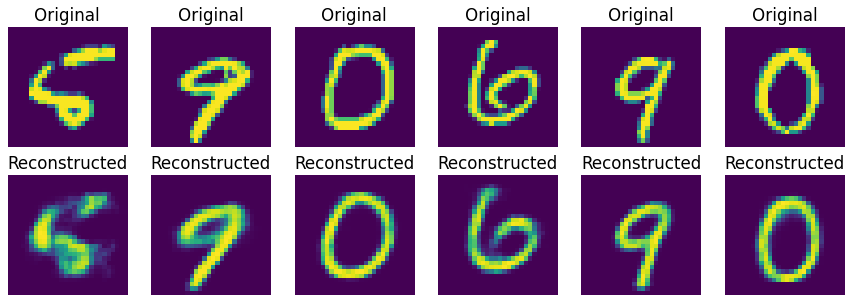

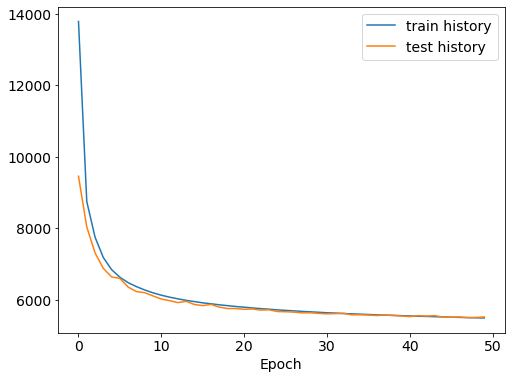

Epoch: 50 | Time: 0m 10s
	Train Loss: 5492.656
	 Val. Loss: 5521.098


In [32]:
n_epochs = 50
train_history = []
valid_history = []

best_valid_loss = float('inf')

for epoch in range(n_epochs):
    
    start_time = time.time()
    
    train_loss = train(Vanilla, train_loader, optimizer, criterion)
    valid_loss = evaluate(Vanilla, test_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(Vanilla.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    plt.figure(figsize=((8,6)))
    
    plt.plot(train_history, label='train history')
    plt.xlabel('Epoch')
    plt.plot(valid_history, label='test history')
    plt.legend()
    
    plt.show()

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

### Sampling

Попробуем восстановить изображения из случайных векторов.

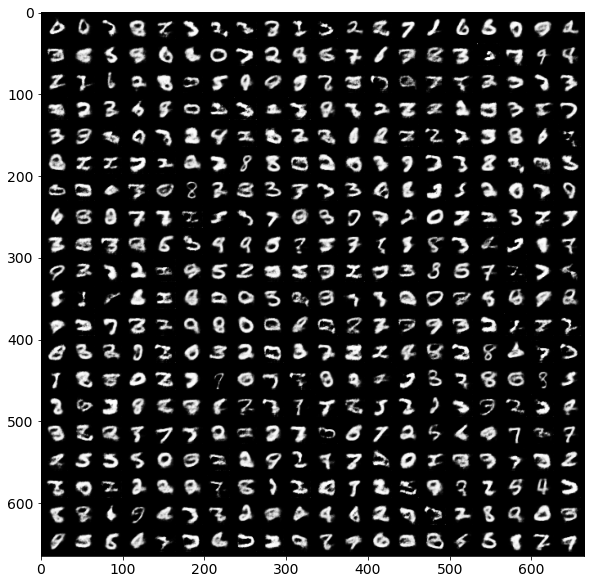

In [33]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


with torch.no_grad():
  latent = torch.randn(400, latent_dim, device=device)
  input = Vanilla.decoder_input(latent)
  output = Vanilla.decoder(input).cpu()

  fig, ax = plt.subplots(figsize=(10, 10))
  show_image(torchvision.utils.make_grid(output,20,5))
  plt.show()

# 2. Variational Autoencoder 

In [34]:
class VAE(nn.Module):
    def __init__(self, in_channels, latent_dim):
        super().__init__()
        hidden_dims = [64, 128]
        self.hid_dims = hidden_dims
        encode = []

        for h_dim in hidden_dims:
            encode.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim, kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*encode)
        self.fc_mu = nn.Linear(6272, latent_dim)
        self.fc_var = nn.Linear(6272, latent_dim)


        decode = []
        self.decoder_input = nn.Linear(latent_dim, 6272)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            decode.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i + 1], kernel_size=3, stride = 2, padding=1, output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
        self.decoder = nn.Sequential(*decode)


        self.final_layer = nn.Sequential(nn.ConvTranspose2d(hidden_dims[-1], out_channels = 1, kernel_size=3, stride=2, padding=1, output_padding=1),
                                         nn.Sigmoid())


    def encode(self, x):
        result = self.encoder(x)

        result = torch.flatten(result, start_dim=1)   
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return mu, log_var
    
    def gaussian_sampler(self, num_samples, mu, logsigma):
        z = logsigma*torch.randn(num_samples, self.latent_dim) + mu

        z = z.to(device)

        samples = self.decode(z)
    
    def decode(self, z):
        result = self.decoder_input(z)

        result = result.view(-1, self.hid_dims[0], 7, 7)

        result = self.decoder(result)
        result = self.final_layer(result)

        return result

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
  
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)

        return  self.decode(z), mu, log_var

Обучим модель:

In [37]:
criterion = loss_vae

in_channels = 1
latent_channels = 8
VariationalAE = VAE(in_channels, latent_channels).to(device)

optimizer = torch.optim.Adam(VariationalAE.parameters(), lr=1e-4)

In [38]:
def train_VAE(model, loader, optimizer, criterion):
  model.train()
    
  train_loss = 0
  history = []
  for batch in loader:
        x, _ = batch
        x = x.to(device)

        optimizer.zero_grad()
        reconstruction, mu, logsigma = model(x)
        reconstruction = reconstruction.view(-1, 1, 28, 28)

        loss = criterion(x, mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

  return train_loss/len(loader)

def evaluate_VAE(model, loader, criterion):
    model.eval()
    
    epoch_loss = 0
    val_loss = 0
    
    with torch.no_grad():
      for i, batch in enumerate(loader):
          x, _ = batch
          x = x.to(device)

          reconstruction, mu, logsigma = model(x)
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(x, mu, logsigma, reconstruction)
          val_loss += loss.item()

          if i == 0:
            idxes = random.randrange(0, 57)
            plt.figure(figsize=(15, 5))
            for k in range(6):
              clear_output(True)

              plt.subplot(2, 6, k+1)
              plt.imshow(x.view(-1, 28, 28)[idxes + k].cpu())
              plt.title('Original')
              plt.axis('off')

              plt.subplot(2, 6, k+7)
              plt.imshow(reconstruction.view(-1, 28, 28)[idxes + k].cpu())
              plt.title('Reconstructed')
              plt.axis('off')
            plt.suptitle('')
            plt.show()

    return val_loss / len(loader)

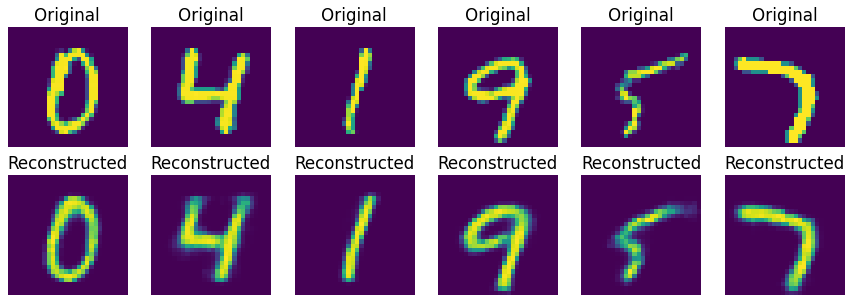

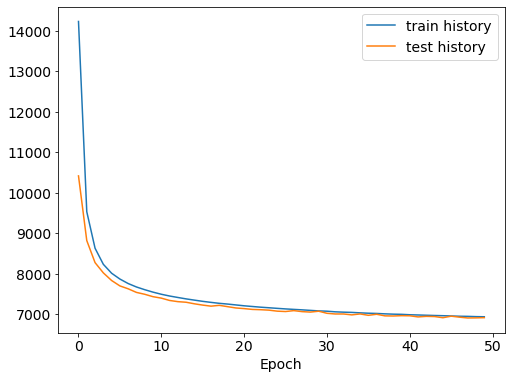

Epoch: 50 | Time: 0m 11s
	Train Loss: 6937.313
	 Val. Loss: 6915.443


In [39]:
from IPython.display import clear_output
import time
import random

n_epochs = 50
train_history = []
valid_history = []

best_valid_loss = float('inf')

for epoch in range(n_epochs):
    
    start_time = time.time()
    
    train_loss = train_VAE(VariationalAE, train_loader, optimizer, criterion)
    valid_loss = evaluate_VAE(VariationalAE, test_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(VariationalAE.state_dict(), 'best-vae-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    plt.figure(figsize=((8,6)))
    
    plt.plot(train_history, label='train history')
    plt.xlabel('Epoch')
    plt.plot(valid_history, label='test history')
    plt.legend()
    
    plt.show()

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

### Sampling

Аналогично для VAE

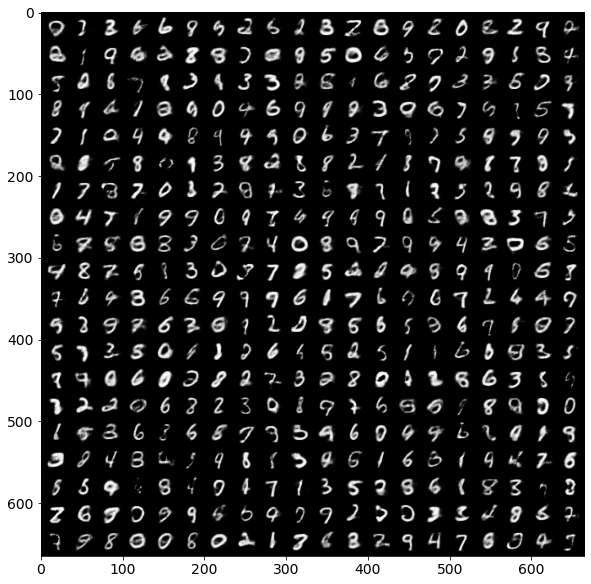

In [40]:
import torchvision.utils

def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


with torch.no_grad():
  latent = torch.randn(400, latent_channels, device=device)
  output = VariationalAE.decode(latent).cpu()

  fig, ax = plt.subplots(figsize=(10, 10))
  show_image(torchvision.utils.make_grid(output,20,5))
  plt.show()

# 3. Conditional Variational Autoencoder 


In [43]:
class CAE(nn.Module):
    def __init__(self, in_channels, latent_dim, num_classes):
        super().__init__()
        hidden_dims = [64, 128]
        self.num_classes = num_classes
        self.hid_dims = hidden_dims
        encode = []

        for h_dim in hidden_dims:
            encode.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim, kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim

        self.encoder = nn.Sequential(*encode)
        self.fc_mu = nn.Linear(6272, latent_dim)
        self.fc_var = nn.Linear(6272, latent_dim)


        decode = []
        self.decoder_input = nn.Linear(latent_dim + num_classes, 6272)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            decode.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i], hidden_dims[i + 1], kernel_size=3, stride = 2, padding=1, output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )
        self.decoder = nn.Sequential(*decode)


        self.final_layer = nn.Sequential(nn.ConvTranspose2d(hidden_dims[-1], out_channels = 1, kernel_size=3, stride=2, padding=1, output_padding=1),
                                         nn.Sigmoid())

    def encode(self, x):
        result = self.encoder(x)
        result = torch.flatten(result, start_dim=1)
        
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)
        
        return mu, log_var
    
    def reparameterize(self, mu, logvar):
        """
        mu: Mean of the latent vector
        logvar: Standard deviation of the latent vector
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu
    
    def decode(self, z, y):
        """
        z: latent vector
        y: int number in range [0,..., 9]
        """
        # int -> one hot representation
        y = F.one_hot(y, num_classes = self.num_classes)

        #concat latent vector with one hot vector
        z = torch.cat([z, y], dim = 1)

        result = self.decoder_input(z)
        result = result.view(-1, self.hid_dims[0], 7, 7)

        result = self.decoder(result)
        result = self.final_layer(result)
        
        return result

    def forward(self, x, y):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z, y), mu, log_var

In [44]:
criterion = loss_vae

in_channels = 1
latent_channels = 8
num_classes = 10 
ConditionalAE = CAE(in_channels, latent_channels, num_classes).to(device)

optimizer = torch.optim.Adam(ConditionalAE.parameters(), lr=1e-4)

In [45]:
def train_CAE(model, loader, optimizer, criterion):
  model.train()
    
  train_loss = 0
  history = []
  for batch in loader:
        x, y = batch
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        reconstruction, mu, logsigma = model(x, y)
        reconstruction = reconstruction.view(-1, 1, 28, 28)

        loss = criterion(x, mu, logsigma, reconstruction)
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

  return train_loss/len(loader)

def evaluate_CAE(model, loader, criterion):
    model.eval()
    
    epoch_loss = 0
    val_loss = 0
    
    with torch.no_grad():
      for i, batch in enumerate(loader):
          x, y = batch
          x = x.to(device)
          y = y.to(device)

          reconstruction, mu, logsigma = model(x, y)
          reconstruction = reconstruction.view(-1, 1, 28, 28)
          loss = criterion(x, mu, logsigma, reconstruction)
          val_loss += loss.item()

          idxes = random.randrange(0, 57)
          if i == 0:
            plt.figure(figsize=(15, 5))
            for k in range(6):
              clear_output(True)

              plt.subplot(2, 6, k+1)
              plt.imshow(x.view(-1, 28, 28)[idxes + k].cpu())
              plt.title('Original')
              plt.axis('off')

              plt.subplot(2, 6, k+7)
              plt.imshow(reconstruction.view(-1, 28, 28)[idxes + k].cpu())
              plt.title('Reconstructed')
              plt.axis('off')
            plt.suptitle('')
            plt.show()

    return val_loss / len(loader)

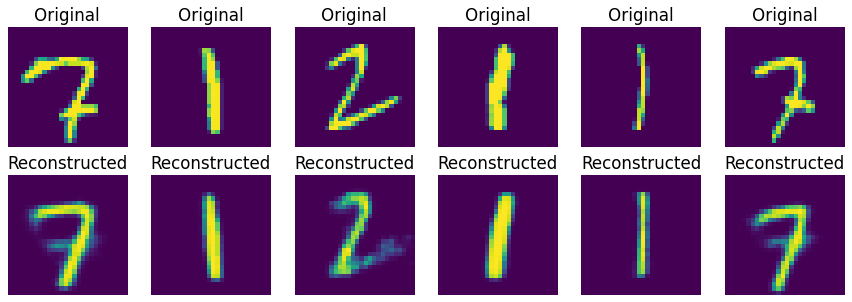

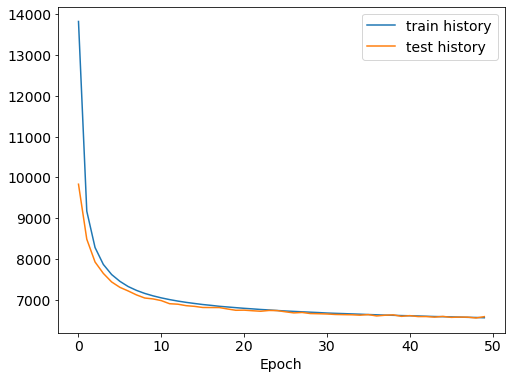

Epoch: 50 | Time: 0m 11s
	Train Loss: 6552.189
	 Val. Loss: 6579.371


In [46]:
n_epochs = 50
train_history = []
valid_history = []

best_valid_loss = float('inf')

for epoch in range(n_epochs):
    
    start_time = time.time()
    
    train_loss = train_CAE(ConditionalAE, train_loader, optimizer, criterion)
    valid_loss = evaluate_CAE(ConditionalAE, test_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(ConditionalAE.state_dict(), 'best-val-model.pt')

    train_history.append(train_loss)
    valid_history.append(valid_loss)

    plt.figure(figsize=((8,6)))
    
    plt.plot(train_history, label='train history')
    plt.xlabel('Epoch')
    plt.plot(valid_history, label='test history')
    plt.legend()
    
    plt.show()

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f}')

### Sampling


Будем подавать CVAE на вход случайный вектор и число, которое мы хотим получить. При этом каждый ряд будет соответствовать различным числам в порядке возрастания. 

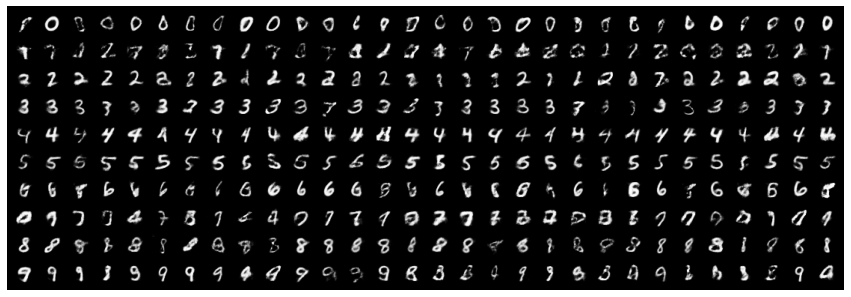

In [71]:
with torch.no_grad():
  latent = torch.randn(300, latent_channels, device=device)
  tensor = torch.tensor((), dtype=torch.int64)
  y = tensor.new_ones((300))

  for i in range(num_classes):
    y[i*30:(i+1)*30] = i

  output = ConditionalAE.decode(latent, y.to(device)).cpu()

  fig, ax = plt.subplots(figsize=(15, 15))

  plt.axis('off')
  show_image(torchvision.utils.make_grid(output,30,9))
  plt.show()